In [1]:
from Matrica import Matrica, JedinicnaMatrica
from math import sin, cos
import matplotlib.pyplot as plt
import numpy as np

In [2]:

class NumerickaIntegracija:
    def __init__(self, sustav, T, t_max):
        self.sustav = sustav
        self.T = T
        self.t_max = t_max
        self.rezultati = []
    
    def pokreni(self, racunaj_gresku=False):
        self.rezultati = [self.sustav.x0]
        greska = Matrica(2, 1, [[0.0], [0.0]])
        t = 0.0
        
        while t < self.t_max:
            t += self.T
            sljedeci_x = self.izracunaj_sljedeci(self.rezultati[-1], t)
            self.rezultati.append(sljedeci_x)
            
            if racunaj_gresku:
                razlika = analiticko_rjesenje(self.sustav.x0, t) - sljedeci_x
                elementi_razlike = [abs(el) for el in razlika.elementi.flatten()]
                greska += Matrica(2, 1, [[el] for el in elementi_razlike])
        if racunaj_gresku: print("Greska:\n", greska)
        return self.rezultati

    def derivacija(self, x, t):
        rez = self.sustav.A * x
        if t is not None and self.sustav.B is not None and self.sustav.ri is not None: 
            rez += (self.sustav.B * self.sustav.r(t))
        return rez
    
    def iscrtaj(self):
        x_1 = []; x_2 = []
        for i in range(len(self.rezultati)):
            rez_i = self.rezultati[i]
            x_1.append(rez_i[0][0])
            x_2.append(rez_i[1][0])
        
        broj_koraka = int(self.t_max/self.T)+1
        koraci = [self.T * broj for broj in range(broj_koraka)]

        x_1 = x_1[0:broj_koraka]; x_2 = x_2[0:broj_koraka]
        plt.plot(koraci, x_1); plt.plot(koraci, x_2)
        plt.title(self.ime)
        plt.show()        

# - RUNGE-KUTTA -

class RungeKutta(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "Runge-Kutta"

    def izracunaj_sljedeci(self, xk, t): #dodan t
        m1 = self.derivacija(xk, t)
        m2 = (self.sustav.A * (xk + ((self.T/2.0) * m1))) 
        if self.sustav.B is not None and self.sustav.ri is not None: m2 += self.sustav.B * self.sustav.r(t + self.T/2.0)
        m3 = (self.sustav.A * (xk + ((self.T/2.0) * m2))) 
        if self.sustav.B is not None and self.sustav.ri is not None: m3 += self.sustav.B * self.sustav.r(t + self.T/2.0)
        m4 = (self.sustav.A * (xk + (self.T * m3)))
        if self.sustav.B is not None and self.sustav.ri is not None: m4 += self.sustav.B * self.sustav.r(t + self.T)
        return xk + ((self.T / 6.0) * (m1 + (2 * m2) + (2 * m3) + m4))

# - TRAPEZ - 

class Trapez(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "Trapezni postupak"
        jedinicna = JedinicnaMatrica(self.sustav.A.br_red, self.sustav.A.br_stup)
        zagrada_1 = jedinicna - (self.T/2.0)*self.sustav.A
        zagrada_2 = jedinicna + (self.T/2.0)*self.sustav.A
        inverz = Matrica(2, 2, np.linalg.inv(zagrada_1.elementi))
        self.R = inverz * zagrada_2
        if self.sustav.B is not None:
            self.S = (T/2.0) * ( inverz * self.sustav.B)

    def izracunaj_sljedeci(self, xk, t): # dodan t
        rezultat = self.R * xk 
        if self.sustav.B is not None:
            rezultat += self.S * (self.sustav.r(t) + self.sustav.r(t+self.T))
        return rezultat

# - EULER -

class Euler(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "Euler"

    def izracunaj_sljedeci(self, xk, t):
        return xk + (self.T * self.derivacija(xk, t))

# - OBRNUTI EULER -

class ObrnutiEuler(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "Obrnuti Euler"
        jedinicna = JedinicnaMatrica(self.sustav.A.br_red, self.sustav.A.br_stup)
        self.P = Matrica(2, 2, np.linalg.inv((jedinicna - (self.T * self.sustav.A)).elementi))
        if self.sustav.B is not None: 
            self.Q = self.P * self.T * self.sustav.B

    def izracunaj_sljedeci(self, xk, t):
        rezultat = self.P * xk
        if self.sustav.B is not None and self.sustav.ri is not None:
            rezultat += (self.Q * self.sustav.r(t+self.T))
        return rezultat 

# - PREDIKTORSKO-KOREKTORSKI POSTUPAK -

class PECE(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "PECE"

    def izracunaj_sljedeci(self, xk, t):
        xkplus1_0 = xk + (self.T * self.derivacija(xk, t))
        return (xk + (self.T/2.0) * (self.derivacija(xk, t) + self.derivacija(xkplus1_0, t+self.T)))

class PECE2(NumerickaIntegracija):
    def __init__(self, sustav, T, t_max):
        super().__init__(sustav, T, t_max)
        self.ime = "PECE2"

    def izracunaj_sljedeci(self, xk, t):
        xkplus1_0 = xk + self.T * self.derivacija(xk, t)
        xkplus1_1 = xk + self.T * self.derivacija(xkplus1_0, t+self.T)
        return xk + self.T * self.derivacija(xkplus1_1, t+self.T)

# - ANALITIČKO RJEŠENJE SUSTAVA -

def analiticko_rjesenje(x0, t):
    x1 = (x0[0][0] * cos(t)) + (x0[1][0] * sin(t))
    x2 = (x0[1][0] * cos(t)) - (x0[0][0] * sin(t))
    return Matrica(2, 1, [[x1], [x2]]) 

# - SUSTAV -

class Sustav:
    def __init__(self, A, x0, B=None, ri=None):
        self.A = Matrica.citaj_iz(A)
        self.B = Matrica.citaj_iz(B)
        self.x0 = Matrica.citaj_iz(x0)
        self.ri = ri
    
    def r(self, t):
        if self.ri == 3:
            return Matrica(2, 1, [[1], [1]])
        elif self.ri == 4:
            return Matrica(2, 1, [[t], [t]])
        else:
            print("r nije zadan")

1. Izračunajte ponašanje sljedećeg sustava s periodom integracije T = 0.01 i t_max = 10 za sve zadane postupke. Sustav predstavlja matematičko njihalo, gdje je x1(t=0) početni odmak od ravnotežnog položaja, a x2(t=0) je početna brzina. Za svaki postupak izračunajte kumulativnu pogrešku koju svaki od postupaka napravi tijekom
izvođenja, na način da zbrojite apsolutnu razliku dobivenog i stvarnog rješenja u svakoj točki integracije, a zbroj prikažete na kraju izvođenja programa. Želimo li npr. dobiti sustav s prigušenjem, element matrice A s indeksom (2,2) treba postaviti na negativnu vrijednost. 

Greska:
 [[22.50072551]
 [23.66292128]]


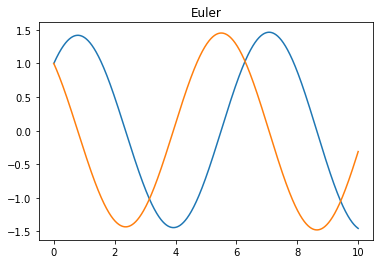

Greska:
 [[21.79644442]
 [22.83794513]]


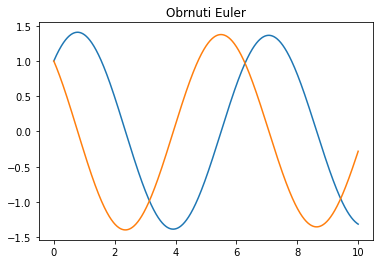

Greska:
 [[0.03874162]
 [0.03690816]]


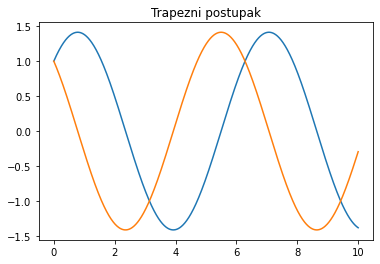

Greska:
 [[3.87779306e-07]
 [3.68706126e-07]]


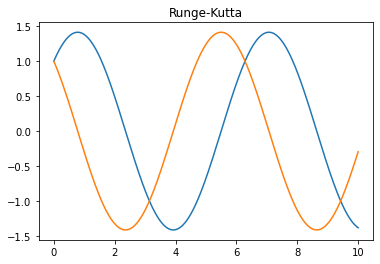

Greska:
 [[0.07755912]
 [0.07376037]]


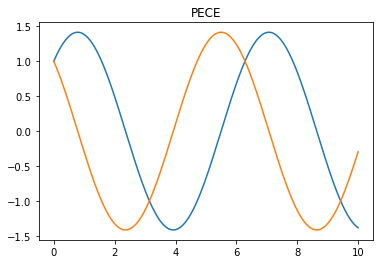

Greska:
 [[21.80072892]
 [22.84244048]]


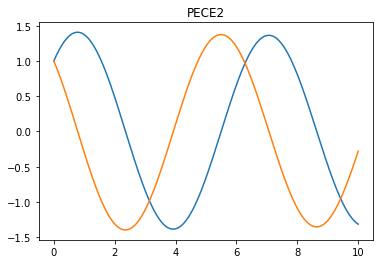

In [3]:
sustav_1 = Sustav("A1.txt", "x0_1.txt")

postupci = [
    Euler(sustav_1, T=0.01, t_max=10),
    ObrnutiEuler(sustav_1, T=0.01, t_max=10),
    Trapez(sustav_1, T=0.01, t_max=10),
    RungeKutta(sustav_1, T=0.01, t_max=10),
    PECE(sustav_1, T=0.01, t_max=10),
    PECE2(sustav_1, T=0.01, t_max=10)
    ]

for postupak in postupci:
    postupak.pokreni(racunaj_gresku=True)
    postupak.iscrtaj()

    f = open("ispis/1/" + postupak.ime + "_1.txt", "w")
    for par in postupak.rezultati:
        f.write(str(par[0][0]) + ", " + str(par[1][0]) + "\n")
    f.close()
    

2. Izračunajte ponašanje sljedećeg sustava. Sustav predstavlja fizikalno njihalo s prigušenjem (zadatak s predavanja). Isprobajte rješavanje s periodom integracije T = 0.1 i t_max = 1 za sve zadane postupke i obratite pažnju na numeričku stabilnost! (uz zadane početne uvjete) Usporedbom rezultata odredite prikladni korak integracije za Runge-Kutta postupak.

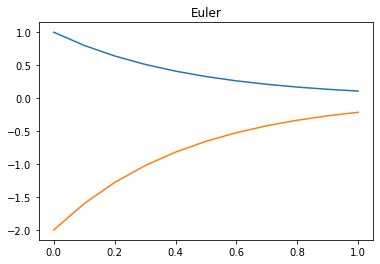

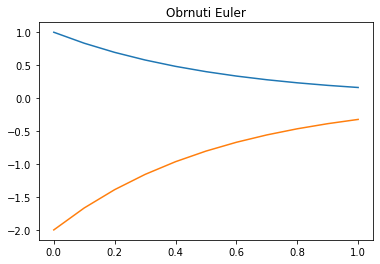

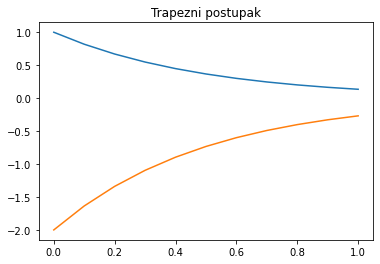

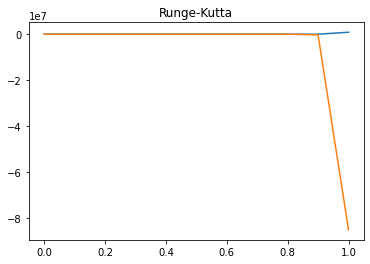

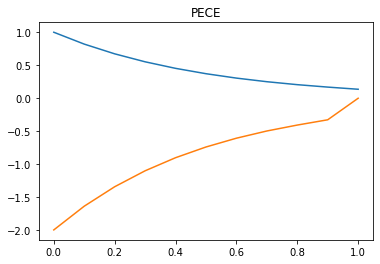

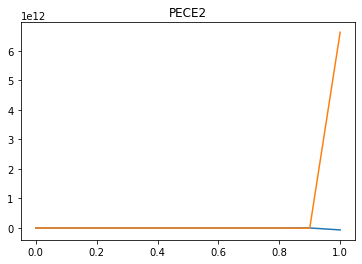

In [4]:
sustav_2 = Sustav("A2.txt", "x0_2.txt")

postupci = [
    Euler(sustav_2, T=0.1, t_max=1),
    ObrnutiEuler(sustav_2, T=0.1, t_max=1),
    Trapez(sustav_2, T=0.1, t_max=1),
    RungeKutta(sustav_2, T=0.1, t_max=1),
    PECE(sustav_2, T=0.1, t_max=1),
    PECE2(sustav_2, T=0.1, t_max=1)
    ]
    
for postupak in postupci:
    postupak.pokreni()
    postupak.iscrtaj()
    f = open("ispis/2/" + postupak.ime + "_2.txt", "w")
    for par in postupak.rezultati:
        f.write(str(par[0][0]) + ", " + str(par[1][0]) + "\n")
    f.close()

3. Izračunajte ponašanje sljedećeg sustava. Isprobajte rješavanje s periodom integracije T = 0.01 i t_max = 10 za sve zadane postupke. 

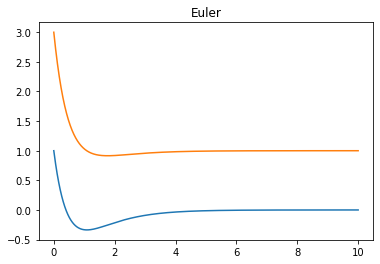

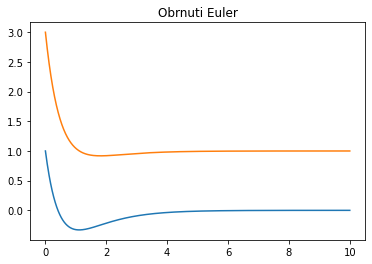

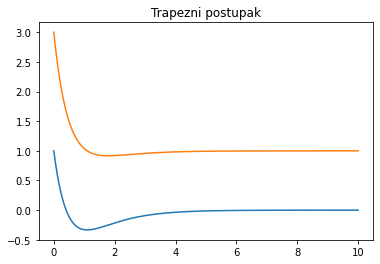

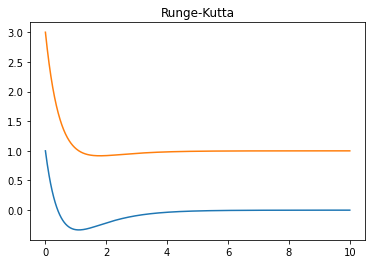

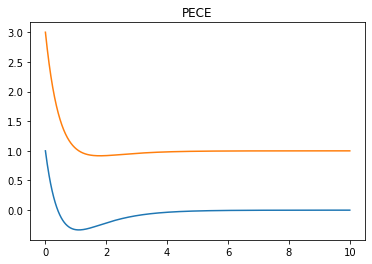

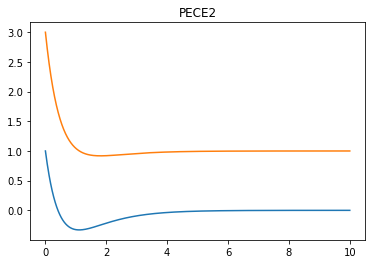

In [5]:
sustav_3 = Sustav("A3.txt", "x0_3.txt", "B3.txt", ri=3)

postupci = [
    Euler(sustav_3, T=0.01, t_max=10),
    ObrnutiEuler(sustav_3, T=0.01, t_max=10),
    Trapez(sustav_3, T=0.01, t_max=10),
    RungeKutta(sustav_3, T=0.01, t_max=10),
    PECE(sustav_3, T=0.01, t_max=10),
    PECE2(sustav_3, T=0.01, t_max=10)
    ]
    
for postupak in postupci:
    postupak.pokreni()
    postupak.iscrtaj()
    f = open("ispis/3/" + postupak.ime + "_3.txt", "w")
    for par in postupak.rezultati:
        f.write(str(par[0][0]) + ", " + str(par[1][0]) + "\n")
    f.close()

4. Izračunajte ponašanje sljedećeg sustava. Isprobajte rješavanje s periodom integracije T = 0.01 i t_max = 1 za sve zadane postupke. 

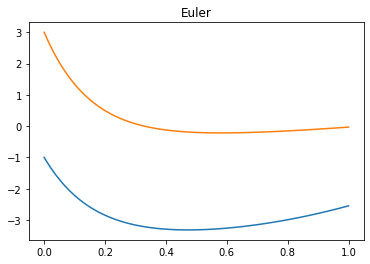

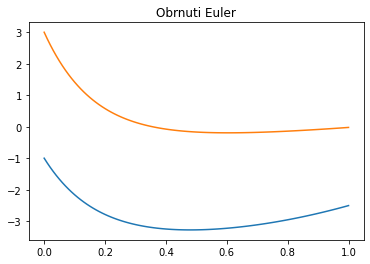

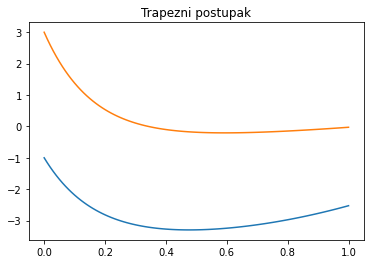

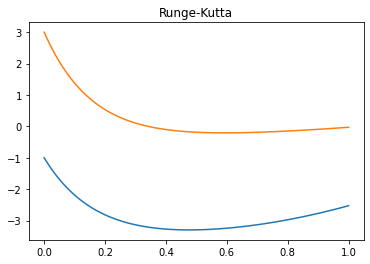

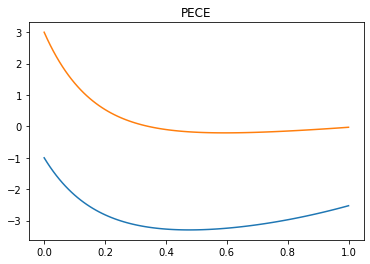

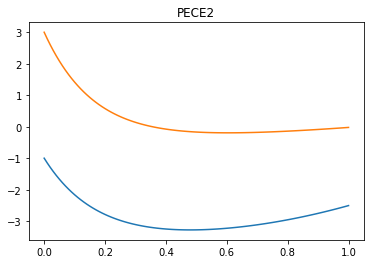

In [6]:
sustav_4 = Sustav("A4.txt", "x0_4.txt", "B4.txt", ri=4)

postupci = [
    Euler(sustav_4, T=0.01, t_max=1),
    ObrnutiEuler(sustav_4, T=0.01, t_max=1),
    Trapez(sustav_4, T=0.01, t_max=1),
    RungeKutta(sustav_4, T=0.01, t_max=1),
    PECE(sustav_4, T=0.01, t_max=1),
    PECE2(sustav_4, T=0.01, t_max=1)
    ]
    
for postupak in postupci:
    postupak.pokreni()
    postupak.iscrtaj()
    f = open("ispis/4/" + postupak.ime + "_4.txt", "w")
    for par in postupak.rezultati:
        f.write(str(par[0][0]) + ", " + str(par[1][0]) + "\n")
    f.close()